# Import libraries, load and transform data

In [1]:

!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [2]:

import warnings  
warnings.filterwarnings("ignore")  

import gc 
import numpy as np  
import pandas as pd  
import itertools  
from collections import Counter
import matplotlib.pyplot as plt  
from sklearn.metrics import  accuracy_score, roc_auc_score, confusion_matrix,classification_report,f1_score


from imblearn.over_sampling import RandomOverSampler 
import accelerate 
import evaluate  
from datasets import Dataset, Image, ClassLabel  
from transformers import ( 
    TrainingArguments,  
    Trainer,  
    ViTImageProcessor,  
    ViTForImageClassification,  
    DefaultDataCollator  
)
import torch
from torch.utils.data import DataLoader  
from torchvision.transforms import CenterCrop,Compose,Normalize,RandomRotation,RandomResizedCrop,RandomHorizontalFlip,RandomAdjustSharpness, Resize, ToTensor  

In [3]:

from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:



image_dict = {}


from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []


for file in sorted((Path('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  
    labels.append(label)  
    file_names.append(str(file))  


print(len(file_names), len(labels))


df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

120000 120000
(120000, 2)


In [5]:
df.head()

,image,label
0,/kaggle/input/cifake-real-and-ai-generated-syn...,FAKE
1,/kaggle/input/cifake-real-and-ai-generated-syn...,FAKE
2,/kaggle/input/cifake-real-and-ai-generated-syn...,FAKE
3,/kaggle/input/cifake-real-and-ai-generated-syn...,FAKE
4,/kaggle/input/cifake-real-and-ai-generated-syn...,FAKE


In [6]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [7]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()
print(df.shape)

(120000, 2)


In [8]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

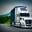

In [9]:

dataset[0]["image"]

In [10]:
labels_subset = labels[:5]
print(labels_subset)

['FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE']


In [11]:
labels_list = ['REAL', 'FAKE'] 
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i  
    id2label[i] = label  

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'REAL', 1: 'FAKE'} 

Mapping of Labels to IDs: {'REAL': 0, 'FAKE': 1}


In [18]:
!pip uninstall -y ipywidgets

Found existing installation: ipywidgets 8.1.5
Uninstalling ipywidgets-8.1.5:
  Successfully uninstalled ipywidgets-8.1.5


In [19]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.0 MB/s eta 0:00:00


In [21]:
!pip list | grep ipywidgets


ipywidgets                               8.1.5


In [22]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [23]:
from datasets import ClassLabel

# Define ClassLabels
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Function to map label names to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Apply mapping
dataset = dataset.map(map_label2id, batched=True)

# Cast the label column
dataset = dataset.cast_column('label', ClassLabels)

# Apply train-test split only to the 'train' split if it exists
if 'train' in dataset:
    dataset_split = dataset['train'].train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
    dataset['train'] = dataset_split['train']
    dataset['test'] = dataset_split['test']
else:
    dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Assign train and test datasets
train_data = dataset['train']
test_data = dataset['test']


Map:   0%|          | 0/25920 [00:00<?, ? examples/s]

Map:   0%|          | 0/17280 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/25920 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/17280 [00:00<?, ? examples/s]

In [24]:
model_str = "dima806/ai_vs_real_image_detection"
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        Resize((size, size)),            
        RandomRotation(90),             
        RandomAdjustSharpness(2),       
        ToTensor(),                       
        normalize                       
    ]
)


_val_transforms = Compose(
    [
        Resize((size, size)),             
        ToTensor(),                       
        normalize                     
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Size:  224


In [25]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [26]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [27]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.800194


In [29]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
   
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

In [30]:
metric_name = "accuracy"
model_name = "ai_vs_real_image_detection"
num_train_epochs = 2
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [32]:
trainer.evaluate()

{'eval_loss': 0.043403297662734985,
 'eval_model_preparation_time': 0.0035,
 'eval_accuracy': 0.9858217592592593,
 'eval_runtime': 141.4132,
 'eval_samples_per_second': 73.317,
 'eval_steps_per_second': 2.291}

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.043228,0.003500,0.986400
2,No log,0.042479,0.003500,0.985436


TrainOutput(global_step=486, training_loss=0.034261570055298354, metrics={'train_runtime': 925.3218, 'train_samples_per_second': 33.614, 'train_steps_per_second': 0.525, 'total_flos': 2.4103108449722696e+18, 'train_loss': 0.034261570055298354, 'epoch': 2.0})

In [34]:
trainer.evaluate()

{'eval_loss': 0.04247914254665375,
 'eval_model_preparation_time': 0.0035,
 'eval_accuracy': 0.9854359567901234,
 'eval_runtime': 91.5588,
 'eval_samples_per_second': 113.239,
 'eval_steps_per_second': 3.539,
 'epoch': 2.0}

In [35]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.04247914254665375, 'test_model_preparation_time': 0.0035, 'test_accuracy': 0.9854359567901234, 'test_runtime': 84.3297, 'test_samples_per_second': 122.946, 'test_steps_per_second': 3.842}


Accuracy: 0.9854
F1 Score: 0.9854


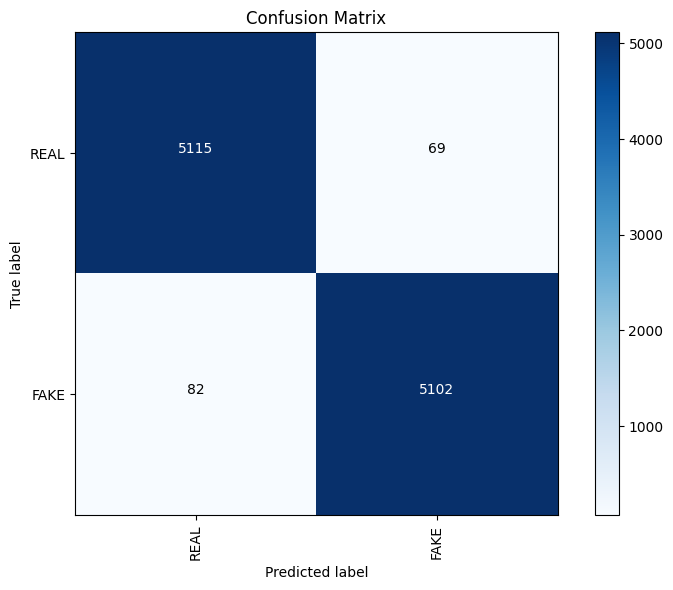


Classification report:

              precision    recall  f1-score   support

        REAL     0.9842    0.9867    0.9855      5184
        FAKE     0.9867    0.9842    0.9854      5184

    accuracy                         0.9854     10368
   macro avg     0.9854    0.9854    0.9854     10368
weighted avg     0.9854    0.9854    0.9854     10368



In [36]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)


def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [37]:

trainer.save_model()

In [38]:

from transformers import pipeline

pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


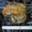

In [39]:

image = test_data[1]["image"]

.
image

In [40]:

pipe(image)

[{'label': 'REAL', 'score': 0.9987921118736267},
 {'label': 'FAKE', 'score': 0.0012079098960384727}]

In [41]:

id2label[test_data[1]["label"]]

'REAL'